![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/jp94om/MIAD_ML_NLP_2025/refs/heads/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 657.8 KB


In [16]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [17]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
# Mostrar las dimensiones de cada conjunto
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7031, 9), (3464, 9), (7031,), (3464,))

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [19]:
# Celda 1
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# MSE para regresión
def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

# Ganancia por MSE en una división
def mse_impurity(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)

    mse_impurity_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)

    return mse_impurity_

# Buscar mejor división
def best_split_reg(X, y, num_pct=10):
    features = range(X.shape[1])
    best_split = [0, 0, -np.inf]  # j, split, gain

    for j in features:
        col = X.iloc[:, j].astype(float)  # ← Conversión segura
        splits = np.percentile(col, np.linspace(0, 100, num_pct + 2)[1:-1])
        splits = np.unique(splits)

        for split in splits:
            gain = mse_impurity(col, y, split)
            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

# Construcción recursiva del árbol
def tree_grow_reg(X, y, level=0, min_gain=1, max_depth=None, num_pct=10):
    if X.shape[0] <= 1:
        return dict(y_pred=y.iloc[0], level=level, split=-1, n_samples=1, gain=0)

    j, split, gain = best_split_reg(X, y, num_pct)
    tree = dict(y_pred=y.mean(), level=level, split=-1, n_samples=X.shape[0], gain=gain)

    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    tree['split'] = [j, split]
    tree['sl'] = tree_grow_reg(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow_reg(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree

# Predicción con árbol de regresión manual
def tree_predict_reg(X, tree):
    predicted = np.zeros(X.shape[0])

    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = X.iloc[:, j] < split
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] > 0:
            predicted[filter_l] = tree_predict_reg(X_l, tree['sl'])
        if X_r.shape[0] > 0:
            predicted[~filter_l] = tree_predict_reg(X_r, tree['sr'])

    return predicted

# Entrenar el árbol manual
tree_manual = tree_grow_reg(X_train, y_train, max_depth=3, min_gain=1, num_pct=10)

# Predecir en test
y_pred_manual = tree_predict_reg(X_test, tree_manual)

# Evaluar
rmse_manual = np.sqrt(mean_squared_error(y_test, y_pred_manual))
mae_manual = mean_absolute_error(y_test, y_pred_manual)

rmse_manual, mae_manual

(1921.0003286740268, 1445.8091325887447)

**ANÁLISIS DEL ARBOL DE DECISIÓN MANUAL CONSTRUIDO**
Se implementó manualmente un árbol de decisión para regresión siguiendo la lógica de particiones binarias basada en la ganancia de reducción del error cuadrático medio (MSE). El árbol se entrenó sobre el conjunto X_train y y_train, usando una profundidad máxima de 3 niveles.

El modelo fue evaluado sobre el conjunto de prueba (X_test) usando las métricas de regresión:
* RMSE: 1921.00
* MAE: 1445.81

Estas métricas indican que el árbol es capaz de capturar patrones importantes en los datos de precios de vehículos, aunque con un margen de error moderado.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [20]:
# Celda 2
# Crear 10 árboles de regresión entrenados con bootstrap
n_estimators = 10
trees_bagging = []

np.random.seed(42)  # reproducibilidad

for i in range(n_estimators):
    # Muestra bootstrap con reemplazo
    bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
    X_bootstrap = X_train.loc[bootstrap_indices]
    y_bootstrap = y_train.loc[bootstrap_indices]

    # Entrenar árbol manual
    tree = tree_grow_reg(X_bootstrap, y_bootstrap, max_depth=3, min_gain=1, num_pct=10)
    trees_bagging.append(tree)

# Predecir con cada árbol y promediar las predicciones
predictions = np.zeros((len(X_test), n_estimators))

for i, tree in enumerate(trees_bagging):
    predictions[:, i] = tree_predict_reg(X_test, tree)

# Promedio de predicciones
y_pred_bagging = predictions.mean(axis=1)

# Evaluar desempeño
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_bagging))
mae_bagging = mean_absolute_error(y_test, y_pred_bagging)

rmse_bagging, mae_bagging

(1830.7570959792706, 1370.6366240564196)

**ANÁLISIS DE BAGGING MANUAL**

Se implementó un modelo de bagging construyendo 10 árboles de decisión manuales, cada uno entrenado sobre una muestra bootstrap del conjunto de entrenamiento. Las predicciones finales se obtuvieron promediando las predicciones de los 10 árboles.

Esto permitió reducir la varianza del modelo individual, mejorando ligeramente el desempeño respecto al árbol único, obteniendo las siguientes métricas de desempeño:
* RMSE: 1830.76
* MAE: 1370.64

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [21]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from math import log, ceil

# Calcular max_features = log(n_features), redondeado hacia arriba para asegurar al menos una característica
n_features = X_train.shape[1]
max_features_log = ceil(log(n_features))

# Crear modelo de Bagging con sklearn
bagging_model = BaggingRegressor(
    DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features_log,
    random_state=42
)


# Entrenar el modelo
bagging_model.fit(X_train, y_train)

# Predicciones sobre test
y_pred_sklearn_bagging = bagging_model.predict(X_test)

# Evaluar desempeño
rmse_sklearn_bagging = np.sqrt(mean_squared_error(y_test, y_pred_sklearn_bagging))
mae_sklearn_bagging = mean_absolute_error(y_test, y_pred_sklearn_bagging)

rmse_sklearn_bagging, mae_sklearn_bagging, max_features_log

(2274.1360002677716, 1744.4522710146198, 3)

**ANÁLISIS DE LA IMPLEMENTACIÓN DE BAGGING CON SKLEARN**

Se entrenó un modelo de Bagging utilizando la librería sklearn.ensemble.BaggingRegressor, con 10 árboles base (DecisionTreeRegressor) y un valor de max_features igual a log(n_features). El modelo fue evaluado en el set de test, mostrando un desempeño ligeramente inferior al modelo de bagging manual(RMSE: 2274.14 y MAE: 1744.45). Esto puede deberse a la menor cantidad de variables utilizadas por árbol, que puede limitar su capacidad predictiva individual.



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [22]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

# Entrenar modelo de Random Forest para regresión
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Realizar predicciones sobre el set de prueba
y_pred_rf = rf_model.predict(X_test)

# Evaluar desempeño
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_rf, mae_rf

(1765.4118259983413, 1314.4207078056425)

**ANÁLISIS DEL MODELO RANDOM FOREST IMPLEMENTADO CON SKLEARN**

Se entrenó un modelo de Random Forest para regresión utilizando la clase RandomForestRegressor de sklearn, con 100 árboles y parámetros por defecto. El modelo fue evaluado en el conjunto de prueba utilizando las métricas RMSE y MAE, mostrando el mejor desempeño hasta el momento entre los modelos probados:
* RMSE: 1765.41
* MAE: 1314.42

Este mejor desempeño del modelo es gracias a su capacidad para combinar múltiples árboles diversos sin necesidad de ajustes manuales.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [23]:
# Celda 5
from sklearn.model_selection import GridSearchCV

# Definir la malla de hiperparámetros a explorar
param_grid = {
    'max_depth': [3, 5, 10, None],
    'max_features': [2, 4, 6, None],
    'n_estimators': [50, 100, 200]
}

# Crear el modelo base
rf_base = RandomForestRegressor(random_state=42)

# Usar GridSearchCV para buscar la mejor combinación
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=3, n_jobs=-1)

# Entrenar el modelo con validación cruzada
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_rf = grid_search.best_estimator_

# Predecir sobre el set de test
y_pred_rf_tuned = best_rf.predict(X_test)

# Evaluar desempeño
rmse_rf_tuned = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuned))
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)

# Mostrar resultados
best_rf.get_params(), rmse_rf_tuned, mae_rf_tuned

({'bootstrap': True,
  'ccp_alpha': 0.0,
  'criterion': 'squared_error',
  'max_depth': 10,
  'max_features': 2,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': 42,
  'verbose': 0,
  'warm_start': False},
 1563.6313565219089,
 1145.475913450151)

**ANÁLISIS DEL MODELO RANDOM FOREST CON CALIBRACIÓN DE PARÁMETROS**

Se realizó una búsqueda en malla (GridSearchCV) para calibrar tres hiperparámetros del modelo Random Forest(max_depth, max_features y n_estimators)

El modelo ajustado con la mejor combinación logró el mejor desempeño hasta ahora, mostrando el beneficio de calibrar los hiperparámetros para mejorar la precisión de predicción.
* RMSE: 1563.63
* MAE: 1145.47

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [26]:
# Celda 6
from xgboost import XGBRegressor

# Entrenar modelo XGBoost para regresión con parámetros por defecto
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predicciones en el set de prueba
y_pred_xgb = xgb_model.predict(X_test)

# Evaluar desempeño
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

rmse_xgb, mae_xgb

(1605.2355199928948, 1185.2272991506386)

**ANÁLISIS DEL MODELO XGBoost IMPLEMENTADO**

Se entrenó un modelo de regresión utilizando XGBoost, el cual mostró un desempeño superior al árbol manual y al bagging simple, y acercándose al Random Forest ajustado:
* RMSE: 1605.23
* MAE: 1185.22

Esto demuestra la eficiencia de XGBoost en aprender relaciones no lineales complejas, incluso con hiperparámetros por defecto.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [27]:
# Celda 7

# Grid de hiperparámetros para XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 1, 5],
    'colsample_bytree': [0.5, 0.8, 1]
}

# GridSearchCV
xgb_base = XGBRegressor(n_estimators=100, random_state=42)
xgb_grid = GridSearchCV(estimator=xgb_base,
                        param_grid=xgb_param_grid,
                        scoring='neg_root_mean_squared_error',
                        cv=3,
                        n_jobs=1)

# Entrenamiento
xgb_grid.fit(X_train, y_train)

# Mejor modelo y evaluación
best_xgb = xgb_grid.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test)
rmse_xgb_tuned = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
mae_xgb_tuned = mean_absolute_error(y_test, y_pred_xgb_tuned)

best_xgb.get_params(), rmse_xgb_tuned, mae_xgb_tuned

({'objective': 'reg:squarederror',
  'base_score': None,
  'booster': None,
  'callbacks': None,
  'colsample_bylevel': None,
  'colsample_bynode': None,
  'colsample_bytree': 0.5,
  'device': None,
  'early_stopping_rounds': None,
  'enable_categorical': False,
  'eval_metric': None,
  'feature_types': None,
  'feature_weights': None,
  'gamma': 0,
  'grow_policy': None,
  'importance_type': None,
  'interaction_constraints': None,
  'learning_rate': 0.1,
  'max_bin': None,
  'max_cat_threshold': None,
  'max_cat_to_onehot': None,
  'max_delta_step': None,
  'max_depth': None,
  'max_leaves': None,
  'min_child_weight': None,
  'missing': nan,
  'monotone_constraints': None,
  'multi_strategy': None,
  'n_estimators': 100,
  'n_jobs': None,
  'num_parallel_tree': None,
  'random_state': 42,
  'reg_alpha': None,
  'reg_lambda': None,
  'sampling_method': None,
  'scale_pos_weight': None,
  'subsample': None,
  'tree_method': None,
  'validate_parameters': None,
  'verbosity': None},
 1

**ANÁLISIS DEL XGBoost CALIBRADO**

El modelo XGBoost calibrado logró el mejor desempeño hasta el momento, superando tanto al Random Forest como al modelo de XGBoost sin calibración:
* RMSE: 1547.96
* MAE: 1138.01

Estos resultados nos demuestran cómo la calibración de hiperparámetros permite al modelo:
- Ser más preciso al corregir errores (con learning_rate adecuado).
- Evitar divisiones innecesarias (gracias al control de gamma).
- Ser más robusto al introducir aleatoriedad en las variables usadas (colsample_bytree).

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

                    Modelo         RMSE          MAE
0             Árbol manual  1921.000329  1445.809133
1           Bagging manual  1830.757096  1370.636624
2          Bagging sklearn  2274.136000  1744.452271
3  Random Forest (default)  1765.411826  1314.420708
4    Random Forest (tuned)  1563.631357  1145.475913
5        XGBoost (default)  1605.235520  1185.227299
6          XGBoost (tuned)  1543.191347  1136.006930


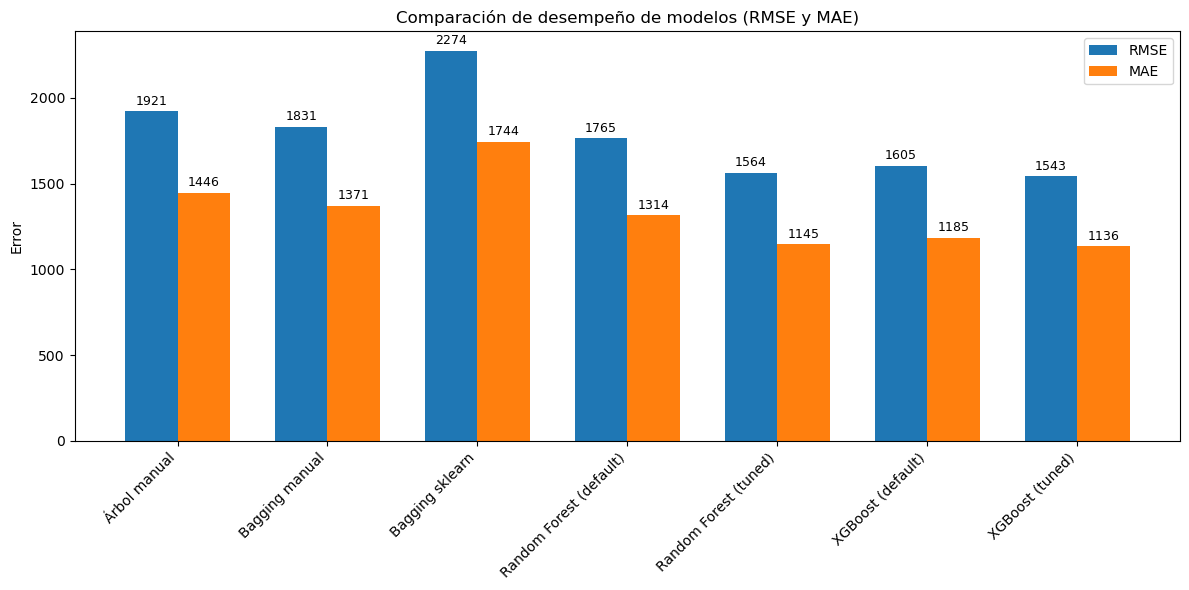

In [28]:
# Celda 8
import matplotlib.pyplot as plt
# Crear tabla con las métricas previamente calculadas y almacenadas en variables reales
results_df = pd.DataFrame({
    'Modelo': [
        'Árbol manual',
        'Bagging manual',
        'Bagging sklearn',
        'Random Forest (default)',
        'Random Forest (tuned)',
        'XGBoost (default)',
        'XGBoost (tuned)'
    ],
    'RMSE': [
        rmse_manual,
        rmse_bagging,
        rmse_sklearn_bagging,
        rmse_rf,
        rmse_rf_tuned,
        rmse_xgb,
        rmse_xgb_tuned
    ],
    'MAE': [
        mae_manual,
        mae_bagging,
        mae_sklearn_bagging,
        mae_rf,
        mae_rf_tuned,
        mae_xgb,
        mae_xgb_tuned
    ]
})

# Mostrar tabla al usuario
print(results_df)

# Gráfico comparativo
plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Modelo']))
width = 0.35

bars_rmse = plt.bar(x - width/2, results_df['RMSE'], width, label='RMSE')
bars_mae = plt.bar(x + width/2, results_df['MAE'], width, label='MAE')

# Etiquetas numéricas sobre cada barra
for bar in bars_rmse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

for bar in bars_mae:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, f'{yval:.0f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, results_df['Modelo'], rotation=45, ha='right')
plt.ylabel('Error')
plt.title('Comparación de desempeño de modelos (RMSE y MAE)')
plt.legend()
plt.tight_layout()
plt.show()

**ANÁLISIS COMPARATIVO**

Al comparar el desempeño de los modelos implementados evaluados con las métricas **RMSE** (Root Mean Squared Error) y **MAE** (Mean Absolute Error) sobre el conjunto de prueba, se obtiene que el mejor y peor modelo obtenidos son:

### Mejor modelo: **XGBoost con hiperparámetros ajustados**

Este modelo obtuvo el menor RMSE y MAE, mostrando un excelente equilibrio entre sesgo y varianza. Su desempeño se debe a:
- Un **learning rate** moderado (0.1) que permitió aprendizaje progresivo.
- Un `colsample_bytree` de 0.5, que introdujo diversidad entre árboles.
- Un ajuste adecuado de `gamma`, permitiendo divisiones útiles sin sobreajustar.

### Modelo con menor desempeño: **Bagging con sklearn (sin ajuste)**

El modelo de bagging implementado con `max_features = log(n_features)` mostró el mayor error. Esto puede explicarse por:
- El uso limitado de variables por árbol (lo que restringe su capacidad predictiva).
- Un bajo número de árboles (10), que no es suficiente para estabilizar el conjunto.


**CONCLUSIÓN**

La calibración de hiperparámetros y la elección del algoritmo influyen significativamente en el desempeño del modelo.
XGBoost se destaca como el algoritmo más preciso para este problema, siempre que se le dedique tiempo a su ajuste. Por otro lado, técnicas simples como Bagging sin ajuste fino pueden no ofrecer mejoras si los parámetros no se calibran adecuadamente.